In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.gen_short_nocall import MEL_Generator_Short, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 42
IMG_SIZE = 224
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 50

## Initial dataframes

Some records were labeled with 'bird' and 'nocall'

In [3]:
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")
call = pd.read_csv("/app/_data/labels_nocall/all_calls.csv")
bad = pd.read_csv("/app/_data/labels_nocall/bad_parts.csv")

In [4]:
nocall["label_id"] = 0
call["label_id"] = 1
bad['label_id']=1

In [5]:
df = pd.concat([call, nocall, bad], axis=0, ignore_index=True).sample(
    frac=1, random_state=SEED
)

In [6]:
df[df["end_sec"] > df["duration"]]

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id


In [7]:
dict_birds = {"nocall": 0, "call": 1}

In [8]:
df["label_id"].value_counts()

1    118038
0     48888
Name: label_id, dtype: int64

In [9]:
df["file_path"] = df["file_path"].str.replace("birdclef-2021/", "")

In [10]:
df

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id
20552,XC283615.ogg,XC283615_27_71,22.71,27.71,amerob,/app/_data/train_short_audio/amerob/XC283615.ogg,28.85,1
102553,XC140283.ogg,XC140283_456_25,451.25,456.25,banswa,/app/_data/train_short_audio/banswa/XC140283.ogg,600.04,1
37538,XC190629.ogg,XC190629_11_4,6.40,11.40,banwre1,/app/_data/train_short_audio/banwre1/XC190629.ogg,30.87,1
59643,XC110258.ogg,XC110258_28_6,23.60,28.60,acowoo,/app/_data/train_short_audio/acowoo/XC110258.ogg,31.28,1
60535,XC138069.ogg,XC138069_82_65,77.65,82.65,amtspa,/app/_data/train_short_audio/amtspa/XC138069.ogg,159.90,1
...,...,...,...,...,...,...,...,...
119879,7019_COR_20190904.ogg,7019_COR_20190904_447_4,442.40,447.40,nocall,/app/_data/train_soundscapes/7019_COR_20190904...,600.00,0
103694,XC153418.ogg,XC153418_70_01,65.01,70.01,bbwduc,/app/_data/train_short_audio/bbwduc/XC153418.ogg,89.26,1
131932,44957_COR_20190923.ogg,44957_COR_20190923_533_19,528.19,533.19,nocall,/app/_data/train_soundscapes/44957_COR_2019092...,600.00,0
146867,26709_SSW_20170701.ogg,26709_SSW_20170701_143_0,138.00,143.00,nocall,/app/_data/train_soundscapes/26709_SSW_2017070...,600.00,0


# train_test_split

In [11]:
train, t_v = train_test_split(df, train_size=0.7, random_state=SEED)
valid, test = train_test_split(t_v, train_size=0.5, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [12]:
train.shape
valid.shape
test.shape

(116848, 8)

(25039, 8)

(25039, 8)

In [13]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/nocall/eff0_nocall_1.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/nocall_6/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore("/app/_data/models/nocall/backup/"),
    keras.callbacks.TerminateOnNaN(),
]

In [15]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB0(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
        ],
    )
    return model

In [16]:
policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [18]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 410

In [19]:
NUM_CLASSES

2

In [20]:
gen_train = MEL_Generator_Short(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    n_classes = NUM_CLASSES,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=True,
    augment=False,
)

gen_valid = MEL_Generator_Short(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    n_classes = NUM_CLASSES,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=False,
    augment=False,
)
gen_test = MEL_Generator_Short(
    df=test,
    n_mels=IMG_SIZE,
    seed=SEED,
    n_classes = NUM_CLASSES,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels/",
    norm_mel=True,
    convert_to_rgb=True,
    shuffle=False,
    augment=False,
)

In [21]:
a = next(iter(gen_train))

array([1, 0], dtype=uint8)

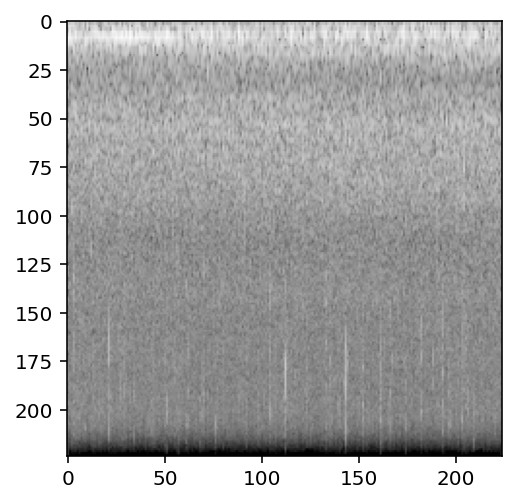

In [22]:
plt.imshow(a[0][4])
a[1][4]

In [23]:
model = get_model()

In [24]:
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    max_queue_size=50,
    workers=20,
    callbacks=callbacks,
)

Epoch 1/100
  1/284 [..............................] - ETA: 0s - loss: 0.6899 - acc: 0.5488 - recall: 0.4220 - precision: 0.5406WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
284/284 [==============================] - ETA: 0s - loss: 0.0612 - acc: 0.9776 - recall: 0.9771 - precision: 0.9778
Epoch 00001: val_loss improved from inf to 0.03913, saving model to /app/_data/models/nocall/eff0_nocall_1.h5
284/284 [==============================] - 256s 900ms/step - loss: 0.0612 - acc: 0.9776 - recall: 0.9771 - precision: 0.9778 - val_loss: 0.0391 - val_acc: 0.9853 - val_recall: 0.9853 - val_precision: 0.9855
Epoch 2/100
284/284 [==============================] - ETA: 0s - loss: 0.0167 - acc: 0.9943 - recall: 0.9943 - precision: 0.9942
Epoch 00002: val_loss improved 

In [25]:
model.evaluate(gen_test)

61/61 [==============================] - 273s 4s/step - loss: 0.0065 - acc: 0.9984 - recall: 0.9984 - precision: 0.9984


[0.0064924233593046665,
 0.9983606338500977,
 0.9983606338500977,
 0.9983606338500977]

In [26]:
pred = model.predict(gen_test)

In [63]:
a = gen_test.__getitem__(8)
b= model.predict(a)

In [64]:
for i in range(410):
    if np.argmax(b[i])!= np.argmax(a[1][i]):
        print(i, np.argmax(b[i]), np.argmax(a[1][i]))

139 0 1


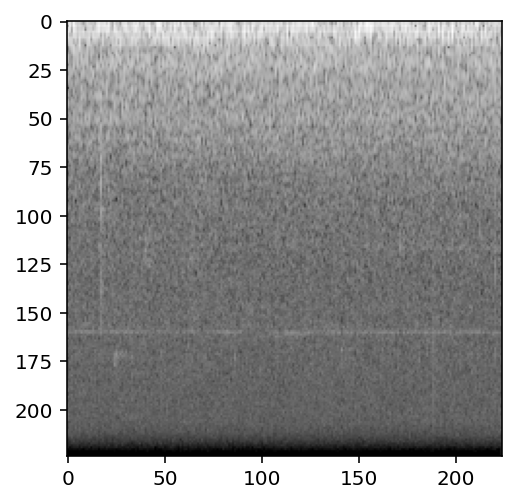

In [65]:
plt.imshow(a[0][139])